# Taller de Análisis de Texto con Tweets en Español

Este taller guía a los estudiantes en el análisis de tweets en español, usando técnicas de limpieza de texto, análisis de frecuencia de palabras y análisis de sentimientos. También incluye preguntas orientadas al negocio.

In [72]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-05-26 16:22:11--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-05-26 16:22:11--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv.3’

Gender_bias

## 1. Configuración e Importación de Librerías
Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos.

In [73]:
!pip install nltk textblob wordcloud
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cargar el Conjunto de Datos
Cargamos el archivo CSV que contiene los tweets y las etiquetas ('biased' o 'non-biased').

In [74]:
# Cargar el conjunto de datos (reemplazar 'ruta/del/archivo.csv' con la ruta del archivo real)
tweets = pd.read_csv('Gender_bias_spanish.csv')
tweets.head()

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased


## 2. Exploración de Datos
Exploraremos el conjunto de datos para entender mejor la distribución de etiquetas y las características de los tweets.

In [75]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Contents  1914 non-null   object
 1   Label     1914 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB


In [76]:
label_counts = tweets['Label'].value_counts()
print("Distribución de etiquetas:")
display(label_counts)

Distribución de etiquetas:


,count
Label,
non-biased,1596
biased,318


In [77]:
tweets.isnull().sum()

,0
Contents,0
Label,0


In [78]:
total_tweets = len(tweets)
biased_proportion = label_counts.get('biased', 0) / total_tweets * 100
non_biased_proportion = label_counts.get('non-biased', 0) / total_tweets * 100

print(f"\nProporción de tweets 'biased': {biased_proportion:.2f}%")
print(f"Proporción de tweets 'non-biased': {non_biased_proportion:.2f}%")


Proporción de tweets 'biased': 16.61%
Proporción de tweets 'non-biased': 83.39%


**Pregunta:** ¿Qué proporción de tweets son 'biased' y 'non-biased'? ¿Por qué podría ser importante esta proporción para el análisis de texto?

**Respuesta:** La proporción de tweets 'biased' es 16. 61% y la proporción de tweets 'non-biased' es 83.39%. Esta proporción es importante para el análisis de texto, ya que muestra que el conjunto de datos está desequilibrado. En este caso hay  más tweets non biased que biased. Al construir un modelo para clasificar los tweets, este desequilibrio puede afectar su rendimiento creando un modelo muy eficaz para identificar non biased tweets, pero deficiente para identificar biased tweets


## 3. Preprocesamiento de Texto
Realizamos una serie de pasos para limpiar y preparar el texto para el análisis: limpieza de caracteres especiales, conversión a minúsculas, y eliminación de stopwords.

In [79]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Záéíóúüñ\s]', '', text)
    # Tokenize and remove stop words
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(cleaned_tokens)

In [80]:
tweets['cleaned_text'] = tweets['Contents'].apply(preprocess_text)

In [81]:
tweets.head()

,Contents,Label,cleaned_text
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased,cabrón tí reciben noticias colchoncito puro ch...
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased,alguien tan amable ir hacerme compra mañana ba...
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased,hahaha si rico nadamas falta presentación
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased,ves programa favorito sólo encuentro temporada...
4,como siempre mi tortilla triunfa mas que otros...,non-biased,siempre tortilla triunfa mas platos


## 4. Análisis de Frecuencia de Palabras por Etiqueta
Contamos las palabras en tweets 'biased' y 'non-biased' y visualizamos las palabras más comunes.

In [82]:
biased_tweets = tweets[tweets['Label'] == 'biased']['cleaned_text']
non_biased_tweets = tweets[tweets['Label'] == 'non-biased']['cleaned_text']

In [83]:
def get_top_words(text_series, n=10):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

In [84]:
top_biased = get_top_words(biased_tweets)
top_non_biased = get_top_words(non_biased_tweets)
df_biased = pd.DataFrame(top_biased, columns=['word', 'count'])
df_non_biased = pd.DataFrame(top_non_biased, columns=['word', 'count'])

<ipython-input-85-7ba9a8c305ea>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df_biased, palette='Reds_r')
<ipython-input-85-7ba9a8c305ea>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df_non_biased, palette='Blues_r')


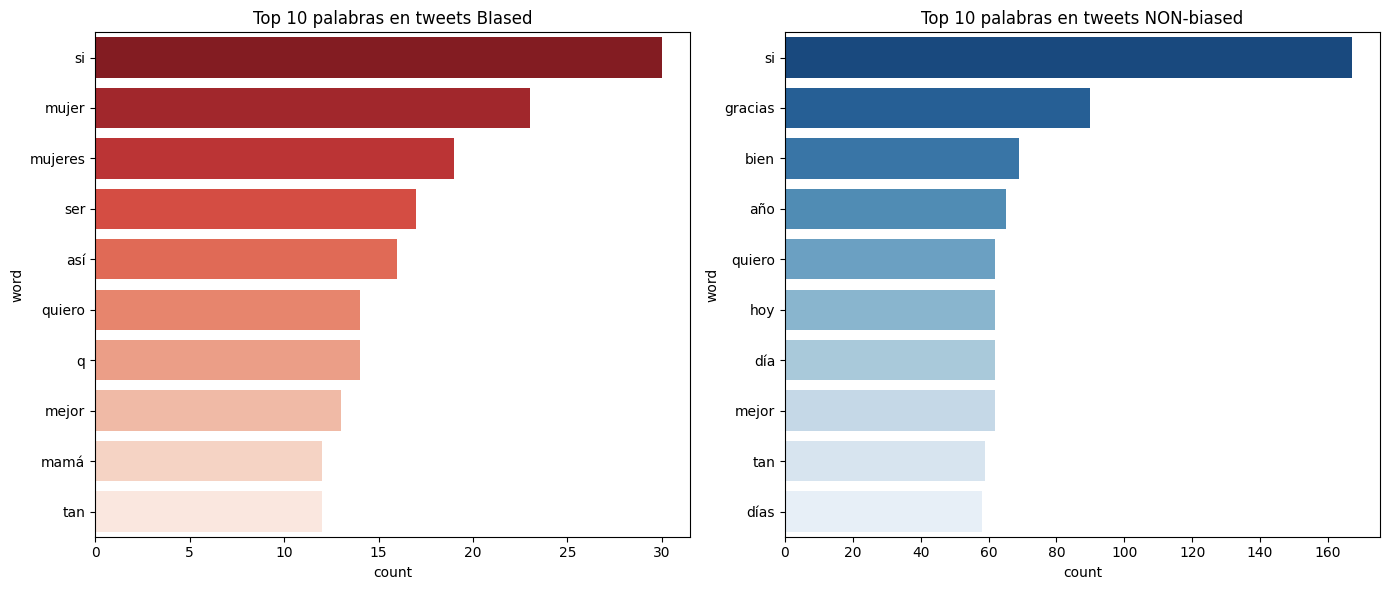

In [85]:
import seaborn as sns

plt.figure(figsize=(14, 6))

# Biased
plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=df_biased, palette='Reds_r')
plt.title('Top 10 palabras en tweets BIased')

# Non-biased
plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=df_non_biased, palette='Blues_r')
plt.title('Top 10 palabras en tweets NON-biased')

plt.tight_layout()
plt.show()

**Preguntas de Análisis de Frecuencia:**
- ¿Qué palabras son más comunes en los tweets 'biased' en comparación con los 'non-biased'?
- ¿Hay palabras que sugieran un sesgo en los tweets etiquetados como 'biased'?
- ¿Cómo podrían usar las empresas esta información para entender mejor las opiniones sesgadas?

**Respuestas**
- Palabras como "mujer" y "mujeres" aparecen entre las 10 principales en tweets biased, pero no entre las 10 principales en los non biased tweets. Esto muestra que las discusiones sobre mujeres son más frecuentes en los biased tweets de este conjunto de datos.
- La presencia de palabras como "mujer" y "mujeres" entre las principales palabras en los biased tweets podría mostrar un enfoque en temas de género dentro del contenido sesgado.
- Las empresas podrían utilizar esta información para comprender cómo se expresan opiniones sesgadas en las conversaciones en línea relacionadas con su marca o sector. Al identificar las palabras y los temas asociados con los tuits sesgados, las empresas pueden adaptar sus estrategias de comunicación para abordar sesgos específicos y analizar cómo se perciben sus productos o servicios en el contexto de conversaciones sesgadas.

## 5. Análisis de Sentimientos
Usaremos `TextBlob` para calcular el sentimiento de cada tweet y luego compararemos la distribución de sentimientos entre tweets 'biased' y 'non-biased'.

In [86]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the preprocessing function to create the 'cleaned_text' column
tweets['cleaned_text'] = tweets['Contents'].apply(preprocess_text)

tweets['sentiment_score'] = tweets['cleaned_text'].apply(get_sentiment)

print("Tweets with sentiment scores:")
display(tweets.head())

Tweets with sentiment scores:


,Contents,Label,cleaned_text,sentiment_score
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased,cabrón tí reciben noticias colchoncito puro ch...,0.0
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased,alguien tan amable ir hacerme compra mañana ba...,0.0
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased,hahaha si rico nadamas falta presentación,0.2
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased,ves programa favorito sólo encuentro temporada...,0.0
4,como siempre mi tortilla triunfa mas que otros...,non-biased,siempre tortilla triunfa mas platos,0.0


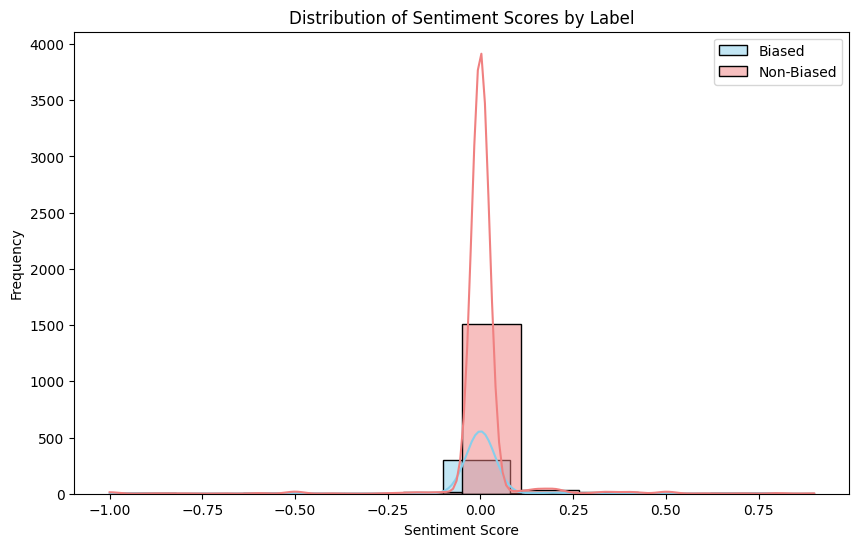

In [87]:
plt.figure(figsize=(10, 6))
sns.histplot(tweets[tweets['Label'] == 'biased']['sentiment_score'], color='skyblue', label='Biased', kde=True)
sns.histplot(tweets[tweets['Label'] == 'non-biased']['sentiment_score'], color='lightcoral', label='Non-Biased', kde=True)
plt.title('Distribution of Sentiment Scores by Label')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Preguntas de Análisis de Sentimientos:**
- ¿Existe una diferencia notable en los sentimientos de tweets 'biased' vs 'non-biased'?
- ¿Qué indica esta diferencia sobre la naturaleza de los tweets sesgados?
- ¿Cómo podrías aplicar el análisis de sentimientos para entender la percepción del público sobre un tema específico?

**Respuestas**
- Sí, existe una diferencia en la distribución de los puntajes de sentimiento entre los biased y non-biased tweets. Aunque ambas distribuciones están centradas alrededor de 0 mostrando neutralidad, los biased tweets muestran una mayor dispersión en los puntajes de sentimiento. Esto significa que tienden a presentar una mayor carga emocional en comparación con los non-biased, cuya distribución es más estrecha y concentrada en valores cercanos a 0
- La diferencia en la distribución del sentimiento sugiere que los tweets sesgados tienden a expresar opiniones más intensas y emocionales, tanto en tono negativo como positivo. Esta mayor carga emocional refleja una intención de influir o generar reacción en el lector, lo cual es característico de los contenidos con sesgo. En cambio, los tweets no sesgados suelen mantenerse en un tono más neutral y objetivo, enfocados en informar más que en persuadir. Por tanto, esta variabilidad en el sentimiento puede ser una señal de subjetividad o polarización.
- El análisis de sentimientos es útil para identificar cómo se siente el público respecto a un tema en particular. Al observar la distribución de emociones se pueden detectar tendencias generales, medir la aceptación o el rechazo y anticipar reacciones sociales. También permite segmentar percepciones por grupos específicos lo que ayuda a personalizar estrategias de comunicación. Este tipo de análisis se convierte en una herramienta clave para tomar decisiones informadas y adaptar mensajes según el estado emocional de la audiencia.







## 6. Visualización con Nube de Palabras
Usamos una nube de palabras para visualizar las palabras más comunes en cada conjunto de tweets.

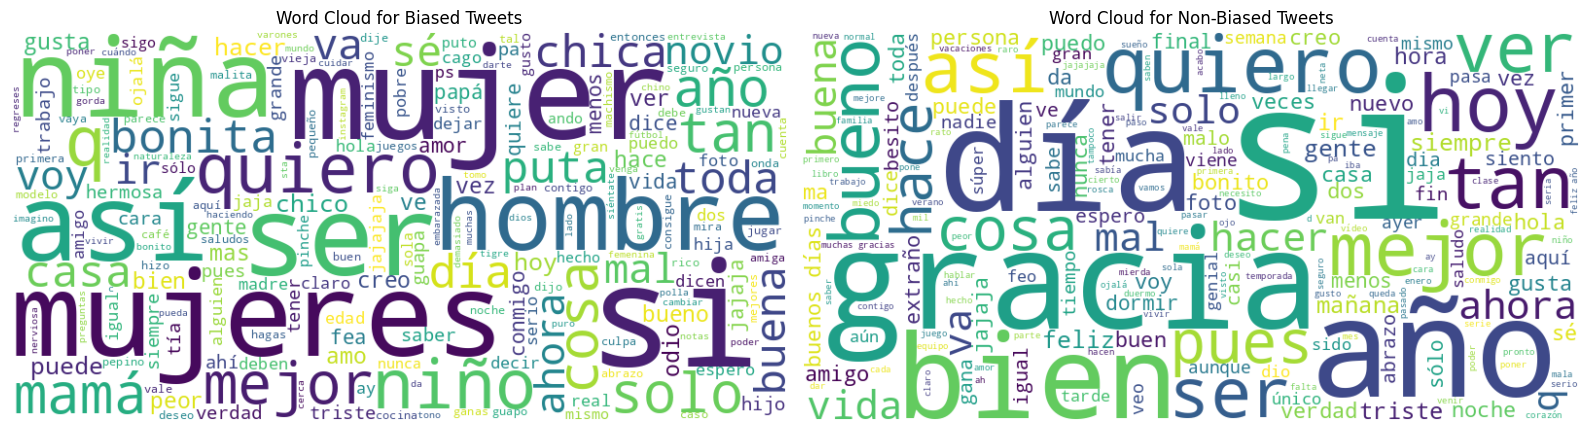

In [88]:
biased_text_combined = ' '.join(biased_tweets)
non_biased_text_combined = ' '.join(non_biased_tweets)

biased_wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(biased_text_combined)
non_biased_wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(non_biased_text_combined)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(biased_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Biased Tweets')

plt.subplot(1, 2, 2)
plt.imshow(non_biased_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Biased Tweets')

plt.tight_layout()
plt.show()

## 7. Conclusiones y Perspectiva de Negocios
En este taller, hemos explorado cómo el análisis de texto puede ofrecer información valiosa sobre el contenido y el sentimiento de los tweets. Reflexionemos sobre algunas preguntas de negocio:
- ¿Cómo podría utilizarse este análisis para mejorar la comunicación de la marca?
- ¿Qué ajustes se podrían hacer en una campaña de marketing si los tweets son predominantemente 'biased'?
- ¿Qué patrones importantes se podrían explorar en un análisis futuro (e.g., análisis de tendencias a lo largo del tiempo)?

**Respuesta**
- El análisis de sentimientos y sesgo permite identificar cómo percibe el público a la marca, lo que ayuda a ajustar el tono y el contenido de los mensajes. Si hay muchas opiniones negativas o cargadas emocionalmente, se pueden aplicar estrategias más empáticas, claras y alineadas con los valores del público. También permite anticipar reacciones y mejorar la conexión emocional con la audiencia, fortaleciendo la imagen de marca.
- Una campaña con muchos tweets sesgados puede indicar que el mensaje es polarizante o malinterpretado. En ese caso, es recomendable revisar el tono, usar un lenguaje más neutral y reforzar la claridad del mensaje. También se podrían incorporar elementos que generen confianza y cercanía para reducir la percepción de parcialidad o manipulación. Escuchar activamente al público y responder de forma transparente ayuda a mejorar la conversación.
- A futuro, sería útil analizar cómo cambian los sentimientos y el sesgo con el tiempo, especialmente tras campañas, eventos o crisis. También se podrían comparar opiniones entre regiones, grupos demográficos o plataformas. Otro patrón relevante es el vínculo entre el tipo de contenido (positivo o negativo) y su nivel de interacción. Estos análisis permiten tomar decisiones más estratégicas basadas en datos y mejorar el impacto comunicativo.



